In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.stats import uniform
import emcee
import corner

%matplotlib inline

### Constants

In [2]:
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
pc_to_km = 3.086e13 # pc to km
yr_to_sec = 31557600.0 # Sec in yr
Myr_to_yr = 1.0e6 # yr in Myr

M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.35
v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km
Dist_LMC = 5.0e4 * pc_to_km # in km
eta_bol = 0.3  # Conversion from bolometric to X-ray luminosity

### SSE data

In [3]:
sse_tmp_mass = np.array([])
sse_tmp_time = np.array([])

names = ["time","mass","mdot","radius"]

f_list = glob.glob("../data/sse_data/mdot_*.dat")

f_list = np.sort(f_list)

for f in f_list:
    datafile = os.path.abspath(f)
    sse_tmp_data = np.genfromtxt(datafile, usecols=(0,2,3,4), dtype="f8,float64,float64,float64", skip_header=1, names=names)

    sse_tmp_time = np.append(sse_tmp_time, max(sse_tmp_data["time"])-1.0)
    sse_tmp_mass = np.append(sse_tmp_mass, sse_tmp_data["mass"][0])


func_sse_tmax = interp1d(sse_tmp_mass, sse_tmp_time, bounds_error=False, fill_value=0.0)

### Mass transfer calculation

In [4]:
def func_MT_forward(M_1_in, M_2_in, A_in):

    M_1_out = M_0 * M_1_in**(1./xi)
    M_2_out = M_1_in + M_2_in - M_1_out
    A_out = A_in * (M_1_in*M_2_in/M_1_out/M_2_out)*(M_1_in*M_2_in/M_1_out/M_2_out)

    return M_1_out, M_2_out, A_out

def get_MT_M1(M_1):
    return M_0 * np.power(M_1, 1.0/xi)

def get_MT_M2(M_1, M_2):
    M1_core = get_MT_M1(M_1)
    return M_1 + M_2 - M1_core

def get_MT_A(M_1, M_2, A):
    M1_MT = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2)
    return A * ((M_1*M_2)/(M1_MT*M2_MT))**2

def J_MT(M_1, M_2, A):
    M1_core = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2, A)
    return M_0/xi * np.power(M_1, 1.0/xi - 1.0) \
        * ((M_1*M_2)/(M1_core * M2_MT))**2
    
def get_dM1_dM1(M_1):
    return M_0/xi * np.power(M_1, 1.0/xi - 1.0)

def get_dA_dA(M_1, M_2, A):
    M1_core = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2)
    return ((M_1*M_2)/(M1_core * M2_MT))**2

In [5]:
print "Test Derivatives"
print ""
print "dM1'/dM1"
print "Numerical:", (get_MT_M1(2.0)-get_MT_M1(1.99)) / 0.01
print "Analytic:", get_dM1_dM1(2.0)
print ""
print "dM2'/dM2"
print "Numerical:", (get_MT_M2(2.0, 2.0) - get_MT_M2(2.0, 1.99)) / 0.01
print "Analytic: 1.0"
print ""
print "dA'/dA"
print "Numerical:", (get_MT_A(2.0, 2.0, 100.0) - get_MT_A(2.0, 2.0, 99.99))/0.01
print "Analytic:", get_dA_dA(2.0, 2.0, 100.0)

Test Derivatives

dM1'/dM1
Numerical: 0.138631667116
Analytic: 0.138777682565

dM2'/dM2
Numerical: 1.0
Analytic: 1.0

dA'/dA
Numerical: 28.9505734372
Analytic: 28.9505734372


### Quick emcee test

In [6]:
def ln_posterior(x, args):
    M1, M2, A = x
    M1_b_out = args
    
    M1_b, M2_b, A_b = func_MT_forward(M1, M2, A)

    ll = 0.0
    lp = 0.0
    
    # Prior
    lp = ln_prior(x)
    
    # M2 observation
#    delta_M_err = 0.2
#    coeff_M = -0.5 * np.log( 2. * np.pi * delta_M_err*delta_M_err )
#    argument_M = -( M1_b - M1_b_out ) * ( M1_b - M1_b_out ) / ( 2. * delta_M_err*delta_M_err )
#    ll += coeff_M + argument_M
    
    return ll+lp


min_mass = 8.0
max_mass = 30.0
alpha = -2.35
min_A = 10.0
max_A = 10000.0
def ln_prior(x):
    
    M1, M2, A = x
    
    lp = 0.0
        
    # P(M1)
    if M1 < min_mass or M1 > max_mass: return -np.inf
    norm_const = (alpha+1.0) / (np.power(max_mass, alpha+1.0) - np.power(min_mass, alpha+1.0))
    lp += np.log( norm_const * np.power(M1, alpha) )

    # P(M2)
    q = M2 / M1
    if q < 0.3 or q > 1.0: return -np.inf
    lp += np.log( (1.0 / 0.7) * (1.0 / M1 ) )

    # P(A)
    if A < min_A or A > max_A: return -np.inf
    norm_const = np.log(max_A) - np.log(min_A)
    lp += np.log( norm_const / A )
    
    return lp

    

In [7]:
M1_true = 12.0
M2_true = 5.0
A_true = 250.0

M1_MT, M2_MT, A_MT = func_MT_forward(M1_true, M2_true, A_true)

print M1_MT, M2_MT, A_MT

2.49029482701 14.509705173 689.324636731


In [8]:
# Define sampler
nwalkers = 32
args = [[M1_MT]]
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=args)


# Set initial walkers
p0 = np.zeros((nwalkers,3))
p0[:,0] = np.random.normal(10.0, 0.5, size=nwalkers)
p0[:,1] = np.random.normal(7.0, 1.0, size=nwalkers)
p0[:,2] = np.random.normal(100.0, 40., size=nwalkers)


nburn = 1000
nsteps = 10000

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=nburn)
    
# Full run
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=nsteps)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


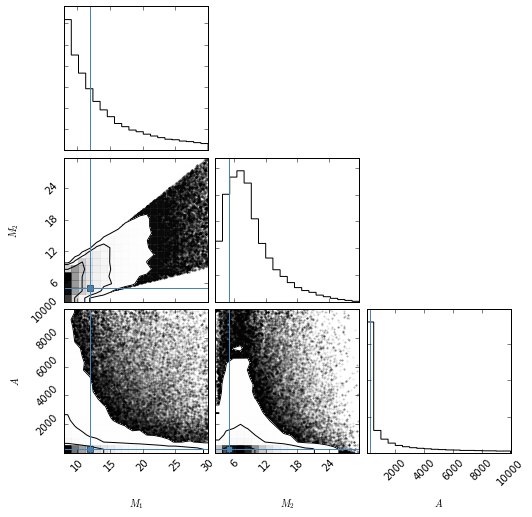

In [9]:
truths = [M1_true, M2_true, A_true]
labels = [r"$M_1$", r"$M_2$", r"$A$"]
fig = corner.corner(sampler.flatchain, labels=labels, truths=truths)

In [12]:
def get_ran_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))
def get_ran_omega(N):
    return 2.0 * np.pi * uniform.rvs(size = N)

def dec_to_rad(theta):
    return np.pi * theta / 180.0
def rad_to_dec(theta):
    return 180.0 * theta / np.pi

def get_theta_proj(alpha, delta, alpha_b, delta_b):
    return np.sqrt((alpha_b-alpha)**2 * np.cos(delta)*np.cos(delta_b) + (delta_b-delta)**2)

def get_omega(alpha, delta, alpha_b, delta_b):
    return np.arctan((delta_b-delta) / ((alpha_b - alpha)*np.cos(delta_b)))

def get_dtheta_dalpha(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return (alpha-alpha_b) * np.cos(delta) * np.cos(delta_b) / theta_proj

def get_dtheta_ddelta(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return - 1.0/(2.0*theta_proj) * (np.cos(delta_b)*np.sin(delta)*(alpha_b-alpha)**2 + 2.0*(delta_b-delta))

def get_domega_dalpha(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return 1.0 / (1.0 + z*z) * z / (alpha_b - alpha)

def get_domega_ddelta(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return - 1.0 / (1.0 + z*z) / ((alpha_b-alpha) * np.cos(delta_b))

def get_J_coor(alpha, delta, alpha_b, delta_b):
    dt_da = get_dtheta_dalpha(alpha, delta, alpha_b, delta_b)
    dt_dd = get_dtheta_ddelta(alpha, delta, alpha_b, delta_b)
    do_da = get_domega_dalpha(alpha, delta, alpha_b, delta_b)
    do_dd = get_domega_ddelta(alpha, delta, alpha_b, delta_b)

    return dt_da*do_dd - dt_dd*do_da


def get_P_theta_proj(theta_proj, v_sys, t_sn):

    # v_sys needs to be in (km/s)
    # t_sn needs to be in s
    # theta_proj should be in radians
    
    # Unitless
    tmp = (v_sys * t_sn * 1.0e6 * yr_to_sec) / Dist_LMC
                
        
    # Define conditional
    conds = [theta_proj>tmp, theta_proj<=tmp]
    funcs = [lambda theta_proj: -np.inf, lambda theta_proj: np.tan(np.arcsin(theta_proj/tmp))/tmp]
    
    prob_out = np.piecewise(theta_proj, conds, funcs)

    return prob_out



def get_P_coor(alpha, delta, alpha_b, delta_b, v_sys, t_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    J_coor = np.abs(get_J_coor(alpha, delta, alpha_b, delta_b))
    P_omega = 1.0 / (2.0 * np.pi)
    P_theta_proj = get_P_theta_proj(theta_proj, v_sys, t_b)
                
    return P_omega * P_theta_proj / J_coor



In [29]:

def ln_posterior(x, args):
#    ra, dec, t_sn = x
    ra, dec, t_b, M1 = x
    ra_b, dec_b, v_sys = args
        
    ll = 0.0
    lp = 0.0
    
    # Prior
    lp = ln_prior(x)
    
    # Get t_sn
    t_sn = (t_b - func_sse_tmax(M1))
    
    likelihood = get_P_coor(dec_to_rad(ra), dec_to_rad(dec), dec_to_rad(ra_b), dec_to_rad(dec_b), v_sys, t_sn)    
    if likelihood <= 0.0 or np.isnan(likelihood): return -np.inf
        
    ll = np.log(likelihood)
    
    return ll+lp

def ln_prior(x):
#    ra, dec, t_b = x
    ra, dec, t_b, M1 = x

    if ra < 70.0 or ra > 90.0 or dec < 30.0 or dec > 50.0 or t_b < 10.0 or t_b > 50.0: return -np.inf
        
#    if t_b < 32.0 or t_b > 38.0: return -np.inf
    if M1 < 8.0 or M1 > 39.0: return -np.inf
            
    return np.log(np.cos(dec_to_rad(dec)))


In [30]:
M1_true = 15.0
ra_true = 77.0
dec_true = 45.0
t_true = 38.0 # 10 Myr
v_sys = 50.0 # km/s

ran_theta = get_ran_theta(1)
ran_omega = get_ran_omega(1)

#t_sn_true = t_true
t_sn_true = t_true - func_sse_tmax(M1_true)

theta_proj_test = np.sin(ran_theta) * v_sys * (t_sn_true*1.0e6*yr_to_sec) / Dist_LMC

delta_dec = theta_proj_test * np.sin(ran_omega)
dec_obs = dec_true + rad_to_dec(delta_dec)

delta_ra = np.sign(np.sin(ran_omega)) * np.sqrt((theta_proj_test**2 - delta_dec**2) / (np.cos(dec_to_rad(dec_true)) * np.cos(dec_to_rad(dec_obs))))
#ra_obs = ra_true + rad_to_dec(theta_proj_test/np.cos(dec_to_rad(dec_true)) * np.cos(ran_omega))
ra_obs = ra_true + rad_to_dec(delta_ra)


print "tmp:", v_sys * (t_sn_true*1.0e6*yr_to_sec) / Dist_LMC

t_sn_i = 34.0 # Myr

print "True (ra, dec)", ra_true, dec_true
print "Observed (ra, dec):", ra_obs, dec_obs



#x = ra_true, dec_true, t_true
x = ra_true, dec_true, t_true, M1_true
args = ra_obs, dec_obs, v_sys

print "True ln_posterior:", ln_posterior(x, args)

tmp: 0.0241689842412
True (ra, dec) 77.0 45.0
Observed (ra, dec): [ 75.05945245] [ 44.89320705]
True ln_posterior: [ 0.43809112]


In [31]:


# Define sampler
nwalkers = 32
args = [[ra_obs, dec_obs, v_sys]]
#sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=args)
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=4, lnpostfn=ln_posterior, args=args)

# Set initial walkers
#p0 = np.zeros((nwalkers,3))
p0 = np.zeros((nwalkers,4))
p0[:,0] = np.random.normal(ra_obs, 0.01, size=nwalkers)
p0[:,1] = np.random.normal(dec_obs, 0.003, size=nwalkers)
p0[:,2] = np.random.normal(t_sn_i, 1.0, size=nwalkers)
p0[:,3] = np.random.uniform(8.0, 20.0, size=nwalkers)


nburn = 1000
nsteps = 5000

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=nburn)
    
# Full run
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=nsteps)


/Library/Python/2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Library/Python/2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


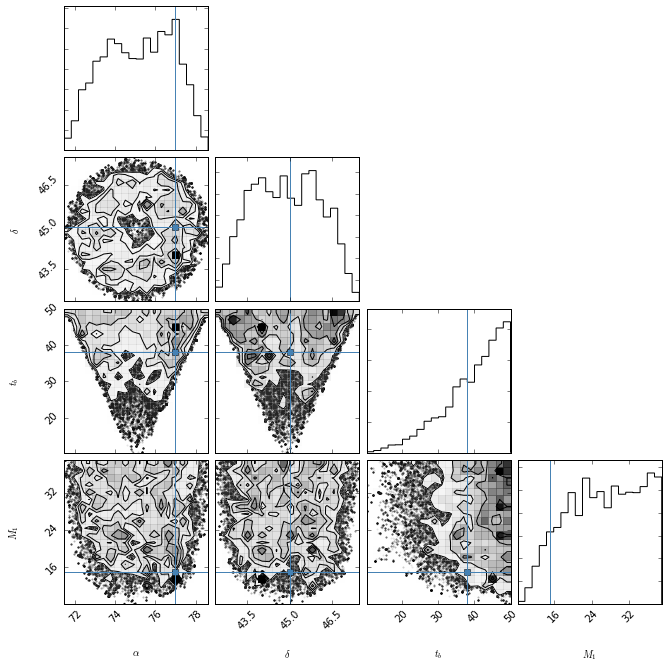

In [32]:
#truths = [ra_true, dec_true, t_true]
truths = [ra_true, dec_true, t_true, M1_true]
#labels = [r"$\alpha$", r"$\delta$", r"$t_b$"]
labels = [r"$\alpha$", r"$\delta$", r"$t_b$", r"$M_1$"]
fig = corner.corner(sampler.flatchain, labels=labels, truths=truths)

In [19]:
ran_ra = np.linspace(ra_obs-4.0, ra_obs+4.0, 100)
ran_dec = np.linspace(dec_obs-3.0, dec_obs+3.0, 100)

xx, yy = np.meshgrid(ran_ra, ran_dec)

args = ra_obs, dec_obs, v_sys


# True time
ran_P_out = np.zeros(xx.shape)

for i in np.arange(len(ran_ra)):
    for j in np.arange(len(ran_dec)):
        ran_x = ran_ra[i], ran_dec[j], t_true
        ran_P_out[j,i] = ln_posterior(ran_x, args)
        

plt.pcolor(xx, yy, ran_P_out, vmin=-35.0, vmax=-20.0)

plt.axvline(ra_true, color='r')
plt.axhline(dec_true, color='r')

plt.show()


# Earlier time
ran_P_out = np.zeros(xx.shape)

for i in np.arange(len(ran_ra)):
    for j in np.arange(len(ran_dec)):
        ran_x = ran_ra[i], ran_dec[j], t_true
        ran_P_out[j,i] = ln_posterior(ran_x, args)
        

plt.pcolor(xx, yy, ran_P_out, vmin=-10.0, vmax=10.0)

plt.axvline(ra_true, color='r')
plt.axhline(dec_true, color='r')

plt.show()


ValueError: too many values to unpack

In [ ]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        plt.plot(chain[:1000], alpha=0.25, color='k', drawstyle='steps')

print prob